In [285]:
import networkx as nx
import random
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [286]:
G = nx.Graph()

In [287]:
import networkx as nx
import random

def generate_graph_dataset(num_elements=100, min_nodes=4, max_nodes=100, seed=42):
    """
    Генерирует список графов и соответствующих меток классов.
    Класс 0: ленточные графы (path graphs)
    Класс 1: смесь циклов, колес, звёзд, полных графов
    """
    if seed is not None:
        random.seed(seed)

    graphs = []
    labels = []

    for i in range(num_elements):
        n = random.randint(min_nodes, max_nodes)
        if i < num_elements // 2:
            # Класс 0 - ленточные графы
            G = nx.path_graph(n)
            # G, removed = remove_random_edges_from_complete_graph(n)
            label = 0
        else:
            # Класс 1 - смесь типов (циклы, колёса, полные, звезды)
            # graph_type = random.choice(['cycle', 'wheel', 'complete', 'star'])

            graph_type = random.choice(['star'])
            if graph_type == 'cycle':
                G = nx.cycle_graph(n)
            elif graph_type == 'wheel':
                # wheel_graph требует min_nodes >= 4
                nn = max(n, 4)
                G = nx.wheel_graph(nn)
            elif graph_type == 'complete':
                G = nx.complete_graph(n)
            elif graph_type == 'star':
                # star_graph строит граф с n+1 вершинами
                G = nx.star_graph(n)

            label = 1

        graphs.append(G)
        labels.append(label)

    return graphs, labels

graphs, classes = generate_graph_dataset(100)

for i in range(0, 100, 25):
    print(f'Граф #{i+1}, класс: {classes[i]}, вершины: {graphs[i].number_of_nodes()}, рёбра: {graphs[i].number_of_edges()}')


Граф #1, класс: 0, вершины: 85, рёбра: 84
Граф #26, класс: 0, вершины: 29, рёбра: 28
Граф #51, класс: 1, вершины: 82, рёбра: 81
Граф #76, класс: 1, вершины: 56, рёбра: 55


Делим на темт-трейн

In [288]:
graph_list, y = generate_graph_dataset(num_elements=300, min_nodes=3, max_nodes=100, seed=42)
train_graphs, test_graphs, y_train, y_test = train_test_split(graph_list, y, test_size=0.1, stratify=y)

Первая таска -- способ через крастчайшие пути

In [289]:
def shortest_path_histogram(graph, max_len=1):
    """Возвращает вектор количества кратчайших путей каждой длины (от 1 до max_len) для графа."""
    # Смотрим только уникальные пары (i, j), i < j
    lengths = []
    for source in graph.nodes():
        sp = nx.single_source_shortest_path_length(graph, source, cutoff=max_len)
        for target, l in sp.items():
            if 1 <= l <= max_len and source < target:
                lengths.append(l)
    counts = np.zeros(max_len)
    for l in lengths:
        counts[l-1] += 1
    return counts

def sp_kernel(train_graphs, test_graphs, max_len=1):
    # Признаковая матрица для train
    phi_train = np.array([shortest_path_histogram(g, max_len=max_len) for g in train_graphs])
    phi_test  = np.array([shortest_path_histogram(g, max_len=max_len) for g in test_graphs])

    # return phi_train, phi_test

    # Ядровые матрицы: скалярно произведение признаковых векторов
    K_train = np.dot(phi_train, phi_train.T)
    K_test  = np.dot(phi_test, phi_train.T)
    return K_train, K_test

# Пример:

K_train, K_test = sp_kernel(train_graphs, test_graphs)
K_train2, K_test2 = sp_kernel(train_graphs, test_graphs, max_len=2)
print(K_train.shape, K_test.shape)


(270, 270) (30, 270)


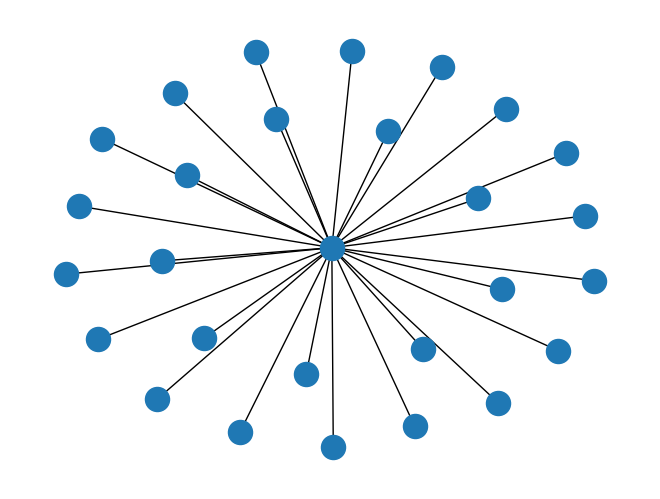

In [290]:
nx.draw(train_graphs[1])

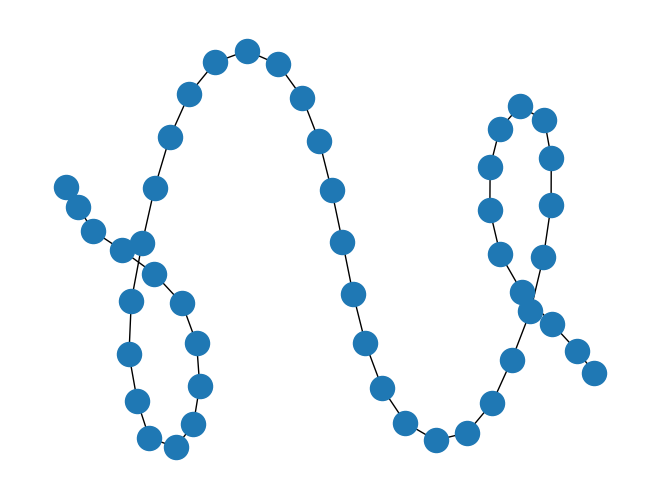

In [295]:
nx.draw(train_graphs[4])

In [296]:
print('--- only 1 feature ---')
model = SVC(kernel='precomputed', random_state=42)
print("Starting Training for the Shortest Path")
model.fit(K_train, y_train)
y_pred = model.predict(K_test)
print("Accuracy for Shortest Path", accuracy_score(y_test, y_pred))
print("Precision for Shortest Path", precision_score(y_test, y_pred))
print("Recall for Shortest Path", recall_score(y_test, y_pred))

print('\n--- 2 features ---')

model = SVC(kernel='precomputed', random_state=42)
print("Starting Training for the Shortest Path")
model.fit(K_train2, y_train)
y_pred = model.predict(K_test2)
print("Accuracy for Shortest Path", accuracy_score(y_test, y_pred))
print("Precision for Shortest Path", precision_score(y_test, y_pred))
print("Recall for Shortest Path", recall_score(y_test, y_pred))

--- only 1 feature ---
Starting Training for the Shortest Path
Accuracy for Shortest Path 0.5333333333333333
Precision for Shortest Path 0.5454545454545454
Recall for Shortest Path 0.4

--- 2 features ---
Starting Training for the Shortest Path
Accuracy for Shortest Path 1.0
Precision for Shortest Path 1.0
Recall for Shortest Path 1.0


## Логично, что при двух факторах точность 1, так как в ленточных графах кратчайших путей длины 1 столько же минус один, сколько путей длины 2, а в звездочных графах - нет.

## Weisfeiler-Lehman Kernel

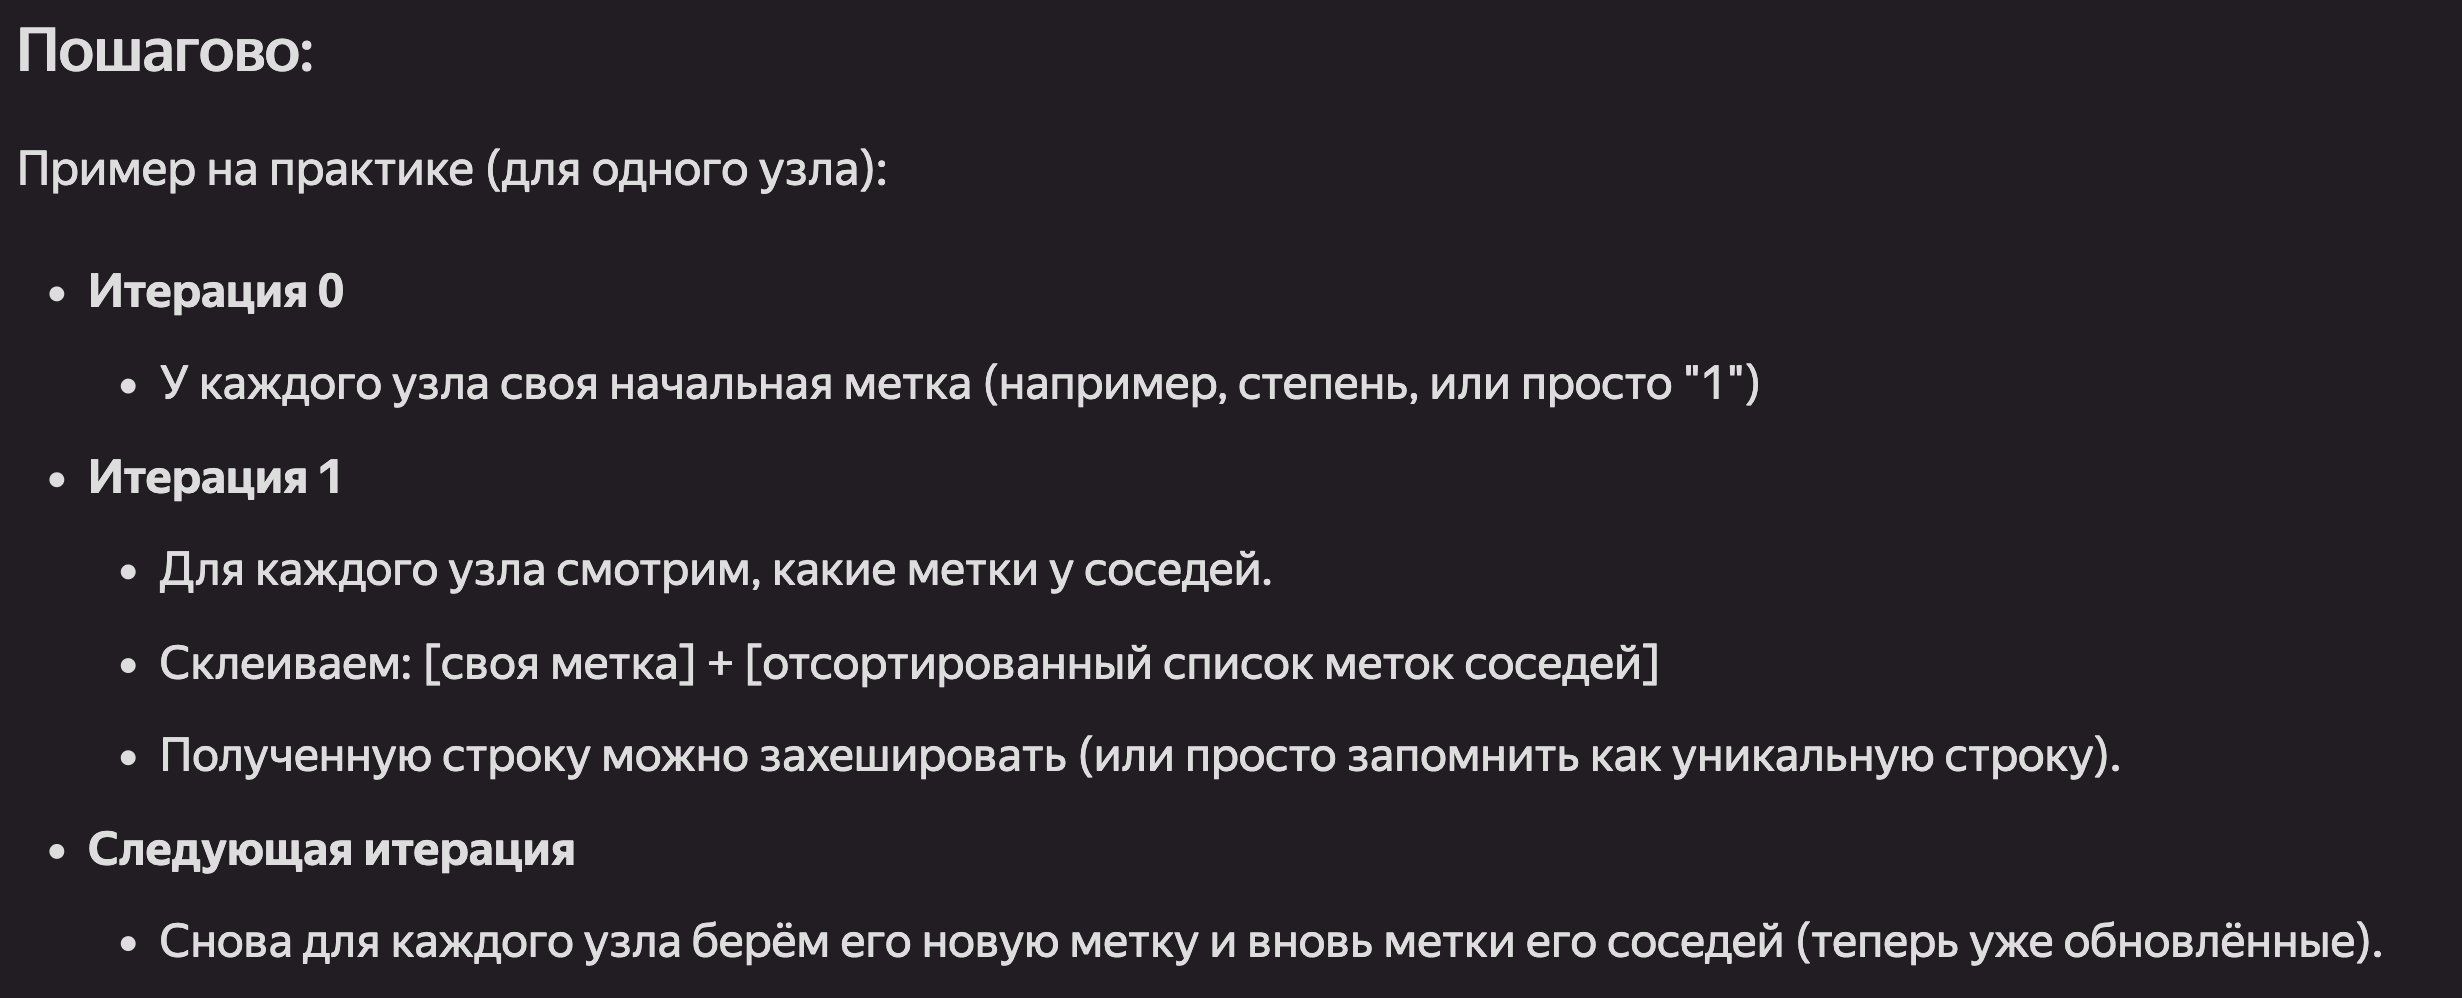

In [297]:
import networkx as nx
import numpy as np
from collections import Counter

def wl_labels(graphs, K_hops):
    '''
    Для каждого графа возвращает bag-of-labels для WL kernel (разделяет по каждому хопу).
    Возвращает:
        list_of_wl_hist: список массивов (по графам), каждый из которых — вектор вхождений меток (на всем цикле WL)
        label_to_index: словарь (метка WL) -> индекс в массиве
    '''
    # 1. Инициализация: метка каждого узла — просто её степень (или 1, если хотим простые одинаковые метки для всех)
    all_graphs_node_labels = []
    for G in graphs:
        labels = {n: str(G.degree(n)) for n in G.nodes()}
        labels = {n: str(1) for n in G.nodes()}
        all_graphs_node_labels.append(labels)

    # Соберём все уникальные метки (за все хопы) чтобы знать размер feature-вектора
    all_wl_labels = set()
    all_graphs_histories = []  # Для каждого графа прибавляем все лейблы на всех хопах

    for g_idx, G in enumerate(graphs):
        labels = all_graphs_node_labels[g_idx].copy()
        history = []  # лист bag-of-labels для каждого hop
        # K_hops+1 тк 0-я итерация — начальные метки ("нулевой раунд")
        for h in range(K_hops+1):
            # Собираем гистограмму меток
            label_freq = Counter(labels.values())
            history.append(label_freq.copy())
            all_wl_labels.update(label_freq.keys())
            # Обновляем метки для каждого узла (если не последний hop)
            if h < K_hops:
                new_labels = {}
                for node in G.nodes():
                    neigh_labels = sorted([labels[neigh] for neigh in G.neighbors(node)])
                    concat_label = labels[node] + "_" + "_".join(neigh_labels)
                    new_labels[node] = hash(concat_label)  # Или оставлять строкой, если хочется, но hash эргономичнее
                labels = {n: str(new_labels[n]) for n in G.nodes()}
        all_graphs_histories.append(history)
    # Теперь all_wl_labels — множество всех меток, которые были за все фазы
    # Пронумеруем
    label_to_index = {lab: i for i, lab in enumerate(sorted(all_wl_labels))}
    # Теперь для каждого графа строим итоговый WL-вектор:
    bags_of_wl = []
    for history in all_graphs_histories:
        # history: list of Counter для каждого hop
        full_hist = Counter()
        for hist in history:
            full_hist += hist
        # Преобразовать Counter в вектор фиксированной длины
        vec = np.zeros(len(label_to_index))
        for lab, cnt in full_hist.items():
            vec[label_to_index[lab]] = cnt
        bags_of_wl.append(vec)
    return bags_of_wl, label_to_index

def wl_kernel(train_graphs, test_graphs, K_hops=2):
    '''
    train_graphs, test_graphs: списки networkx графов
    K_hops: сколько итераций WL пройти
    Возвращает:
        K_train: (n_train, n_train) WL kernel matrix
        K_test: (n_test, n_train) WL kernel matrix
    '''
    # Получить bag-of-WL-words (вектор) для каждого графа
    phi_train, label_map = wl_labels(train_graphs, K_hops)
    # Чтобы фичи test_graphs были в том же пространстве
    # Нужно повторно пронумеровать тестовые метки по train-мэппингу
    def bag_for_test(graphs):
        all_wl_labels = list(label_map.keys()) # только train labels!
        idx_map = label_map
        all_graphs_node_labels = []
        for G in graphs:
            labels = {n: str(G.degree(n)) for n in G.nodes()}
            all_graphs_node_labels.append(labels)
        all_graphs_histories = []
        for g_idx, G in enumerate(graphs):
            labels = all_graphs_node_labels[g_idx].copy()
            history = []
            for h in range(K_hops+1):
                label_freq = Counter(labels.values())
                history.append(label_freq.copy())
                # Обновляем метки для каждого узла (если не последний hop)
                if h < K_hops:
                    new_labels = {}
                    for node in G.nodes():
                        neigh_labels = sorted([labels[neigh] for neigh in G.neighbors(node)])
                        concat_label = labels[node] + "_" + "_".join(neigh_labels)
                        new_labels[node] = hash(concat_label)
                    labels = {n: str(new_labels[n]) for n in G.nodes()}
            all_graphs_histories.append(history)
        bags_of_wl = []
        for history in all_graphs_histories:
            full_hist = Counter()
            for hist in history:
                full_hist += hist
            # Трансформировать только по train label_map
            vec = np.zeros(len(idx_map))
            for lab, cnt in full_hist.items():
                if lab in idx_map:
                    vec[idx_map[lab]] = cnt
                # НЕ добавлять неизвестные метки вектора — просто игнорировать
            bags_of_wl.append(vec)
        return bags_of_wl

    phi_test = bag_for_test(test_graphs)
    phi_train = np.stack(phi_train, axis=0)
    phi_test = np.stack(phi_test, axis=0)

    # return phi_test, phi_train

    # Kernel — скалярное произведение feature-векторов
    K_train = phi_train @ phi_train.T
    K_test = phi_test @ phi_train.T
    return K_train, K_test


Проверка:

In [305]:
print(wl_labels(train_graphs, 0)[0][4]) # ленточный граф, при 0 хопах все вершины - с единичкой
print(wl_labels(train_graphs, 1)[0][4])

[47.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.
  0.  0.  0.  0.  0.  0.  0.  0. 47.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. 45.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Моделька:

In [306]:
print('-- 0 hops --')
K_train, K_test = wl_kernel(train_graphs, test_graphs, K_hops=0)

model = SVC(kernel='precomputed', random_state=42)
print("Starting Training for the WL")
model.fit(K_train, y_train)
y_pred = model.predict(K_test)
print("Accuracy for WL", accuracy_score(y_test, y_pred))
print("Precision for WL", precision_score(y_test, y_pred))
print("Recall for WL", recall_score(y_test, y_pred))

print('\n-- 1 hops --')
K_train1, K_test1 = wl_kernel(train_graphs, test_graphs, K_hops=1)

model = SVC(kernel='precomputed', random_state=42)
print("Starting Training for the WL")
model.fit(K_train1, y_train)
y_pred = model.predict(K_test1)
print("Accuracy for WL", accuracy_score(y_test, y_pred))
print("Precision for WL", precision_score(y_test, y_pred))
print("Recall for WL", recall_score(y_test, y_pred))

print('\n-- 2 hops --')
K_train2, K_test2 = wl_kernel(train_graphs, test_graphs, K_hops=20)

model = SVC(kernel='precomputed', random_state=42)
print("Starting Training for the WL")
model.fit(K_train2, y_train)
y_pred = model.predict(K_test2)
print("Accuracy for WL", accuracy_score(y_test, y_pred))
print("Precision for WL", precision_score(y_test, y_pred))
print("Recall for WL", recall_score(y_test, y_pred))

-- 0 hops --
Starting Training for the WL
Accuracy for WL 0.7
Precision for WL 1.0
Recall for WL 0.4

-- 1 hops --
Starting Training for the WL
Accuracy for WL 1.0
Precision for WL 1.0
Recall for WL 1.0

-- 2 hops --
Starting Training for the WL
Accuracy for WL 0.9333333333333333
Precision for WL 1.0
Recall for WL 0.8666666666666667


In [307]:
prec_list = []
rec_list = []
acc_list = []
for i in range(50):
  K_train, K_test = wl_kernel(train_graphs, test_graphs, K_hops=i)
  model = SVC(kernel='precomputed', random_state=42)
  model.fit(K_train, y_train)
  y_pred = model.predict(K_test)
  acc_list += [accuracy_score(y_test, y_pred)]
  prec_list += [precision_score(y_test, y_pred)]
  rec_list += [recall_score(y_test, y_pred)]

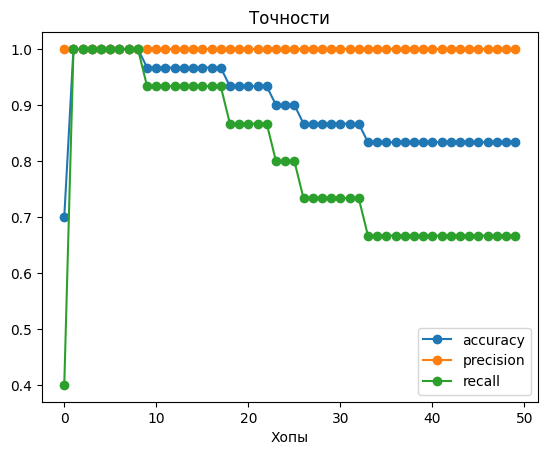

In [308]:
plt.plot(range(50), acc_list, 'o-', label='accuracy')
plt.plot(range(50), prec_list, 'o-', label='precision')
plt.plot(range(50), rec_list, 'o-', label='recall')
plt.xlabel('Хопы')
plt.title('Точности')
plt.legend()

# Падает recall, то есть как будто теряем полноту классификации. Это довольно странно, но кажется ок, так как отличие между классами графов должно быть в первом приближении, а детализация может приводить к переобучению